# Playground Q-learning Mountain Car

### Author: Buelent Uendes 

This is an example notebook for one of the workshops regarding Reinforcement learning at the VU summer school 2022. 

In [2]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

# Let's create the environment first


In [3]:
env_name = 'MountainCar-v0'
env = gym.make(env_name)

#Set the seed
env.action_space.seed(42)

[42]

## Let's first checkout some of the properties of the problem 

In [4]:
print('The observation space is ', env.observation_space)
print('The action space is ', env.action_space)

The observation space is  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
The action space is  Discrete(3)


In this problem, we have a continous observation space, with discrete action spaces. One way to deal with continous observation space is to discretize the space. Important to reset the environment, use the following command.

Important to reset the environment, use the following command:

In [5]:
#Resets the environment to the start state
env.reset()

array([-0.5232211,  0.       ], dtype=float32)

In [6]:
# We can sample a random action from the environment via
env.step(env.action_space.sample())

(array([-0.5242239 , -0.00100283], dtype=float32), -1.0, False, {})

## First step: Random agent

It is always a good idea to test out the environment and start to play around. For this purpose, I create an agent that plays the game with random actions.

In [10]:
env = gym.make(env_name)
env.reset()
for _ in range(500):
    if _ % 100 == 0:
        print(_)
    action = env.step(env.action_space.sample())
    env.render()

# This will stop the environment after
env.close()

0
100
200
300
400


## Recap: 

As a recap, the main four functions for the environment space are:
- **env.reset():** 
    Resets the environment and obtain initial starting observation
- **env.render():** 
    Visualize the environment. Important Pygame needs to be installed for this
- **env.step(action):** 
    Applies an action to it. It outputes next state, reward, done and info
- **env.close():** 
    Closes the pop-up frame of the visualized environment

## Main problem: Let's learn an agent that uses Q-learning!

In the first step we need to digitize the observation space. Here we want to equally split the space into 19 bins using the function np.digitize. 

In [11]:
low = env.observation_space.low
high =env.observation_space.high

In [12]:
#You could play around with the bin size!
bin_size = 20
bin_x = np.linspace(low[0], high[0], bin_size)
bin_velocity = np.linspace(low[1], high[1], bin_size)

We need to keep in mind that we basically have bin_size - 1 number of bins, as no value can be higher or lower than the max or min value for x-position and velocity!

In [13]:
bins = [bin_x, bin_velocity]
values = np.random.random((10,2))+5
digitized = []

for i in range(len(bins)):
    digitized.append(np.digitize(values[:,i], bins[i])-1)


In [14]:
digitized

[array([19, 19, 19, 19, 19, 19, 19, 19, 19, 19]),
 array([19, 19, 19, 19, 19, 19, 19, 19, 19, 19])]

It is important to keep in mind that we do not want to discretize the state space too much, given the GLIE theorem. GLIE theorem stands for 'Greedy in the Limit with Infinite Exploration', which means that the state action pairs Q(s,a) will converge to the optimal ones if all state-action pairs are explored infinitely many times and the policy converges to the greedy one. For this reason, we want to have not too many states and we need to tune the epsilon rate in such a way that it converges to zero.

In [15]:
def discretizing_obs_state(env_name, state, bin_size):
    #State incorporates the observation state
    #State[0] is x position
    #State[1] is y position
    
    env = gym.make(env_name)
    env.reset()
    
    #Get the low and high values of the environment space
    low = env.observation_space.low
    high =env.observation_space.high
    
    #You could play around with the bin size!
    bin_size = 20
    bin_x = np.linspace(low[0], high[0], bin_size)
    bin_velocity = np.linspace(low[1], high[1], bin_size)
    
    #Append the two bins
    bins = [bin_x, bin_velocity]
    print(bins)
    #Now we can make use of the function np.digitize and bin it
    digitized_state = []
    
    for i in range(len(bins)):
        digitized_state.append(np.digitize(state[i], bins[i])-1)
    
    return digitized_state


In [16]:
def create_Q_table(bin_size, action_space):
    state_space = bin_size - 1
    return np.zeros((state_space,state_space, action_space))

## Now we can put it together and work out a Q learning agent 

In [19]:
class QAgent():
    
    def __init__(self, env_name, discount_rate = 0.95, bin_size = 20):
        
        #create an environment
        self.env_name = env_name
        self.env = gym.make(env_name)
        
        #Set the discount rate
        self.discount_rate = discount_rate
        
        #The algorithm has then 3 different actions
        #0: Accelerate to the left
        #1: Don't accelerate
        #2: Accelerate to the right
        self.action_space = range(env.action_space.n)
        
        #Set the bin size
        self.bin_size = bin_size
        
        #State incorporates the observation state
        #State[0] is x position
        #State[1] is y position
    
        #Get the low and high values of the environment space
        self.low = self.env.observation_space.low
        self.high = self.env.observation_space.high
    
        #You could play around with the bin size!
        bin_x = np.linspace(self.low[0], self.high[0], self.bin_size)
        bin_velocity = np.linspace(self.low[1], self.high[1], self.bin_size)
    
        #Append the two bins
        self.bins = [bin_x, bin_velocity]
    
    def discretize_state(self, state):
        #Now we can make use of the function np.digitize and bin it
        self.state = state
        
        #Create an empty state
        digitized_state = []
    
        for i in range(len(self.bins)):
            digitized_state.append(np.digitize(self.state[i], self.bins[i])-1)
        
        #Returns the discretized state from an observation
        return digitized_state
    
    def create_Q_table(self):
        self.state_space = self.bin_size - 1
        self.Qtable = np.zeros((self.state_space, self.state_space, self.env.action_space.n))

    def train(self, simulations, learning_rate = 1, epsilon = 1, adapting_learning_rate = False):
        #Initialize variables that keep track of the rewards
        
        self.rewards = []
        self.average_rewards = []
        
        #Call the Q table function to create a randomly initialized Q table
        self.create_Q_table()
        
        #Initialize the learning rate and the epsilon
        self.learning_rate = learning_rate
        
        #Set minimum epsilon, so here we want a minimum exploration rate of 0.05
        self.epsilon_minimum = 0.05
        
        if adapting_learning_rate:
            self.learning_rate = 1
        
        self.epsilon = epsilon
        
        for i in range(simulations):
            
            if i % 5000 == 0:
                print(f'Please wait, the algorithm is learning! The current simulation is {i}')
            #Initialize the state
            state = self.env.reset()
        
            #Set a variable that flags if an episode has terminated
            done = False
        
            #Discretize the state space
            
            state = self.discretize_state(state)
            
            #Set the rewards to 0
            total_rewards = 0
            
            #Loop until an episode has terminated
            while not done:
                
                #Pick an action based on epsilon greedy
                #Pick random action
                if np.random.uniform(0,1) > 1-self.epsilon:
                    #This picks a random action from 0,1,2
                    action = np.random.choice(self.action_space)
                    
                #Pick a greedy action
                else:
                    action = np.argmax(self.Qtable[state[0],state[1],:])
                    
                #Now sample the next_state, reward, done and info from the environment
                
                next_state, reward, done, info = self.env.step(action)
                
                #Now discretize the next_state
                next_state = self.discretize_state(next_state)
                
                #Adjust Q-values
                
                #Target value 
                Q_target = (reward + self.discount_rate*np.max(self.Qtable[next_state[0], next_state[1]]))
                
                #Calculate the delta
                delta = self.learning_rate * (Q_target - self.Qtable[state[0], state[1], action])
                
                #Update the Q-value
                self.Qtable[state[0], state[1], action] = self.Qtable[state[0], state[1], action] + delta
                
                #Update the reward and the hyperparameters
                total_rewards += reward
                state = next_state
                
            #Decay epsilon, here we decay both the epsilon and learning rate with the number of simulations
            delta = (self.epsilon - self.epsilon_minimum)/(i+1)
            self.epsilon -= delta
            if adapting_learning_rate:
                self.learning_rate = self.learning_rate/np.sqrt(i)
            self.rewards.append(total_rewards)
            
            #Calculate the average score over 100 episodes
            if i % 100 == 0:
                self.average_rewards.append(np.mean(self.rewards))
                
                #Initialize a new reward list, as otherwise the average values would reflect all rewards!
                self.rewards = []
        
        print('The simulation is done!')
        
    def visualize_rewards(self):
        plt.plot(100*(np.arange(len(self.average_rewards))+1), self.average_rewards)
        plt.title('Average reward over the past 100 simulations')
        plt.xlabel('Number of simulations')
        plt.ylabel('Average reward')
    
    def play_game(self):
        #Get the optimized strategy:
        done = False
        #Start the game
        state = self.env.reset()
        while not done:
            state = self.discretize_state(state)
            #Pick the best acction from the saved Qtable
            action = np.argmax(self.Qtable[state[0],state[1],:])
            next_state, reward, done, info = self.env.step(action)
            state = next_state
            self.env.render()
            #Pause to make it easier to watch
            time.sleep(0.05)
        #Close the pop-up window
        #self.env.close()

## Let's run this simulation let's say 15,000 times 

In [20]:
Qagent = QAgent(env_name, bin_size = 20)
Qagent.train(15000, learning_rate = 0.1)

Please wait, the algorithm is learning! The current simulation is 0
Please wait, the algorithm is learning! The current simulation is 5000
Please wait, the algorithm is learning! The current simulation is 10000
The simulation is done!


## Now we can plot the results 

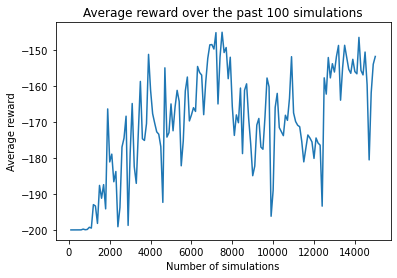

In [21]:
Qagent.visualize_rewards()

## Lastly, and finally we want to see if our QAgent learned the problem 

In [27]:
Qagent.play_game()

Done! Our agent learned via TD control how to solve the mountain car problem!